<a href="https://colab.research.google.com/github/Maanimus/Algorithm/blob/main/Rebalaccing_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import math 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb


from tensorflow import keras
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from google.cloud import bigquery

In [2]:
!gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

Copying gs://ml-design-patterns/fraud_data_kaggle.csv...
/ [1 files][470.7 MiB/470.7 MiB]                                                
Operation completed over 1 objects/470.7 MiB.                                    


In [3]:
fraud_data = pd.read_csv('fraud_data_kaggle.csv')
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
fraud_data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [5]:
# drop a few columns we won't use for this demo 
fraud_data = fraud_data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
fraud_data = pd.get_dummies(fraud_data) # one-hot encoding 

In [6]:
fraud_data.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1


In [7]:
# Split into separate dataframes
fraud = fraud_data[fraud_data['isFraud'] == 1]
not_fraud = fraud_data[fraud_data['isFraud'] == 0]

In [8]:
print(f'Lenth of fraud : {len(fraud)}')
print(f'Lenth of Not-fraud : {len(not_fraud)}')
print(f'ratio_fraud :{len(fraud)/len(fraud_data)*100:.2f}%')

Lenth of fraud : 8213
Lenth of Not-fraud : 6354407
ratio_fraud :0.13%


In [9]:
#Take a random sample of non-fraud data 
# the .005 frac will give us around an 80/20 split of not-fraud/fraud samples
not_fraud_sample = not_fraud.sample(random_state = 2, frac = .005)

In [10]:
# Put the data back together and shuffle 
fraud_data = pd.concat([not_fraud_sample,fraud])
fraud_data = shuffle(fraud_data, random_state=2)

In [11]:
# Look at our data balance after downsampling
fraud_data['isFraud'].value_counts()

0    31772
1     8213
Name: isFraud, dtype: int64

In [12]:
#Make cross validation set 
train_test_split = int(len(fraud_data) * .8)

train_data = fraud_data[:train_test_split]
test_data = fraud_data[train_test_split:]

train_labels = train_data.pop('isFraud')
test_labels = test_data.pop('isFraud')

XGBRegressor
논문 Decision Tree Learning for Fraud Detection in Consumer Energy Consumption(IEEE,Christa Cody) 에 따라 의사결정 트리 모델 적용

In [13]:
model = xgb.XGBRegressor(
    objective='reg:linear'
)

In [14]:
model.fit(train_data.values, train_labels)

[14:52:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [15]:
# Get some test predictions
y_pred = model.predict(test_data.values)

In [16]:
# To build a confusion matrix using the scikit utility, we'll need the values as ints

y_pred_formatted = []

for i in y_pred:
  y_pred_formatted.append(int(round(i)))

In [17]:
cm = confusion_matrix(test_labels.values, y_pred_formatted)
print(cm)

[[6360   43]
 [  82 1512]]


In [18]:
# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

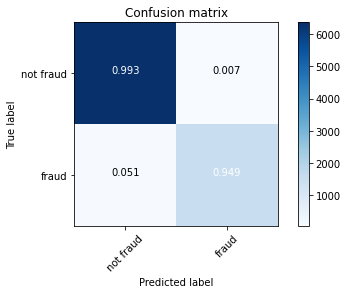

In [19]:
# With downsampling, our model's accuracy on fraud is almost as good as non-fraud examples
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

In [20]:
cm.sum(axis = 0)

array([6442, 1555])

In [21]:
accuracy = (cm[0][0]+cm[1][1])/cm.sum()*100
precision = cm[0][0]/cm.sum(axis=0)[0]*100
recall = cm[0][0]/cm.sum(axis=1)[0]*100
f1_score = precision*recall/(precision + recall) * 2

In [22]:
print(f'Accuracy : {accuracy:.2f}')
print(f'Precision : {precision:.2f}')
print(f'Recall : {recall:.2f}')
print(f'F1 score : {f1_score:.2f}')

Accuracy : 98.44
Precision : 98.73
Recall : 99.33
F1 score : 99.03
